# Парсинг страниц Auto.ru

In [47]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn

## Сбор данных: парсинг и выделение признаков
С помощью скрипта autoru_parser.py мы можем выделить следующие признаки для каждого объявления:
1. Вещественные:
    - Рубли/Доллары/Евро
    - Пробег
2. Целочисленные:
    - Количество дверей
    - Объем багажника
    - Количество владельцев 
    - Координаты
    - Регион (по кодам)
    - Год
3. Категориальные (в т.ч. бинарные):
    - Лицензия - бинарный (True, False)
    - Авто класс - бинарный (True/False)
    - С салона - бинарный (True, False)
    - Таможня - бинарный (True, False)
    - PTS - (Dublicate, Original)
    - Доступность - In_Stock, Out_Of_Stock
    - Категория (для конкретной выборки Mersedes - cars)
    - Цвет (в виде кода, можно преобразовать в более общие категории, а не по точным оттенкам)
    - Временная зона
    - Тип автомобиля 
    - Марка автомобиля
    - Модель автомобиля


4. Другие:
    - Описание
    - Фото/изображения
    - Имя автомобиля - строковый/категориальный
    - VIN - индивидуальный шифр

In [48]:
with open('autoru_parsing_result2.txt', 'r') as file:
    lines = file.readlines()

# Uncomment to see lines:
# lines

Пока не будем никак работать с изображениями, поэтому уберем их:

In [49]:
prefix = '//avatars.' # to remove unnececcasy images for now
newlines = [x for x in lines if not x.startswith(prefix)]

# Uncomment to see lines without image links:
# newlines

Выделим признаки, которые будем исследовать:

In [50]:
signs = ['Рубли', 'Пробег', 'Количество дверей', 'Объем багажника', 
         'Количество владельцев', 'Год', 'Лицензия', 'С салона', 'Цвет', 
         'Временная зона', 'Марка автомобиля', 'Модель автомобиля', 'Тип автомобиля']

Для каждого автомобиля выделим имеющиеся признаки:

In [51]:
separator = '=================================================================================================================================\n'
index = 0
labels = [[]]
for i in range(len(newlines)):
    if newlines[i]:
        first_word = newlines[i].split(':')[0]
        if first_word in signs:
            second_word = newlines[i].split(': ')[1].replace("\n","")
            labels[index].append((first_word, second_word))
        if newlines[i] == separator:
            index += 1
            labels.append([])
labels.pop()

# Uncomment to see the collected objects:
# labels

[]

In [52]:
data = pd.DataFrame(columns=signs)

for label in labels:
    labeldict = {}
    for i in range(len(label)):
        labeldict[label[i][0]] = label[i][1]
    data = data.append(labeldict, ignore_index=True)

In [53]:
data.head()

,Рубли,Пробег,Количество дверей,Объем багажника,Количество владельцев,Год,Лицензия,С салона,Цвет,Временная зона,Марка автомобиля,Модель автомобиля,Тип автомобиля
0,1360000,174000,4,NaN,4,2010,******|18,False,#040001,+04,Mercedes-Benz,S-Класс,SEDAN
1,4310000,28000,4,NaN,1,2019,******|716,False,#97948F,MSK,Mercedes-Benz,A-Класс AMG,SEDAN
2,7120000,15000,5,NaN,1,2020,******|716,False,#FAFBFB,MSK,Mercedes-Benz,GLE,ALLROAD_5_DOORS
3,1520000,137000,4,NaN,4,2011,******|156,False,#040001,MSK,Mercedes-Benz,E-Класс,SEDAN
4,380000,375000,4,NaN,4,2003,NaN,False,#040001,MSK,Mercedes-Benz,C-Класс,SEDAN


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Рубли                  1695 non-null   object
 1   Пробег                 1724 non-null   object
 2   Количество дверей      1724 non-null   object
 3   Объем багажника        481 non-null    object
 4   Количество владельцев  1537 non-null   object
 5   Год                    1724 non-null   object
 6   Лицензия               732 non-null    object
 7   С салона               1724 non-null   object
 8   Цвет                   1724 non-null   object
 9   Временная зона         1724 non-null   object
 10  Марка автомобиля       1724 non-null   object
 11  Модель автомобиля      1724 non-null   object
 12  Тип автомобиля         1724 non-null   object
dtypes: object(13)
memory usage: 175.2+ KB


## Отбор признаков
- Уберем признак "Лицензия", так как более половины значений в нем - пропущенные. 
- Уберем те автомобили, у которых не известна цена в рублях (позже можно просто будет сделать конвертации между долларами/евро/рублями).
- Пустые значения колонки 'Пробег' заполним медианным значением.
- Для пустых ячеек признака "Количество владельцев" поставим хотя бы 1.
- Создадим три списка признаков, соответствующие их группам: вещественные, целочисленные и категориальные. 

In [55]:
data = data[data['Рубли'].notna()]
data = data.drop(['Лицензия'], axis=1)
data['Количество владельцев'].fillna(1, inplace=True)
data['Объем багажника'].fillna(data['Объем багажника'].notnull().astype('int').mean(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 0 to 1723
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Рубли                  1695 non-null   object
 1   Пробег                 1695 non-null   object
 2   Количество дверей      1695 non-null   object
 3   Объем багажника        1695 non-null   object
 4   Количество владельцев  1695 non-null   object
 5   Год                    1695 non-null   object
 6   С салона               1695 non-null   object
 7   Цвет                   1695 non-null   object
 8   Временная зона         1695 non-null   object
 9   Марка автомобиля       1695 non-null   object
 10  Модель автомобиля      1695 non-null   object
 11  Тип автомобиля         1695 non-null   object
dtypes: object(12)
memory usage: 172.1+ KB


In [56]:
real_features = ['Пробег', 'Рубли']
discrete_features = ['Количество дверей', 'Объем багажника', 'Количество владельцев', 'Год']
cat_features = data.columns.drop(real_features).drop(discrete_features).tolist()

Первичный анализ:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 0 to 1723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Пробег  1695 non-null   int64
 1   Рубли   1695 non-null   int64
dtypes: int64(2)
memory usage: 39.7 KB


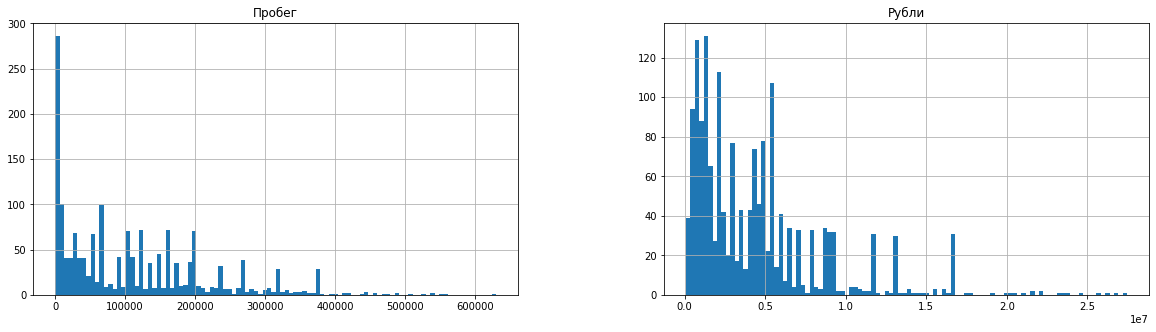

In [57]:
#data[discrete_features].describe()
data[real_features] = data[real_features].astype('int')
data[real_features].info()
real_hist = data[real_features].hist(bins=100, figsize=(20,5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 0 to 1723
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Количество дверей      1695 non-null   int64
 1   Объем багажника        1695 non-null   int64
 2   Количество владельцев  1695 non-null   int64
 3   Год                    1695 non-null   int64
dtypes: int64(4)
memory usage: 66.2 KB


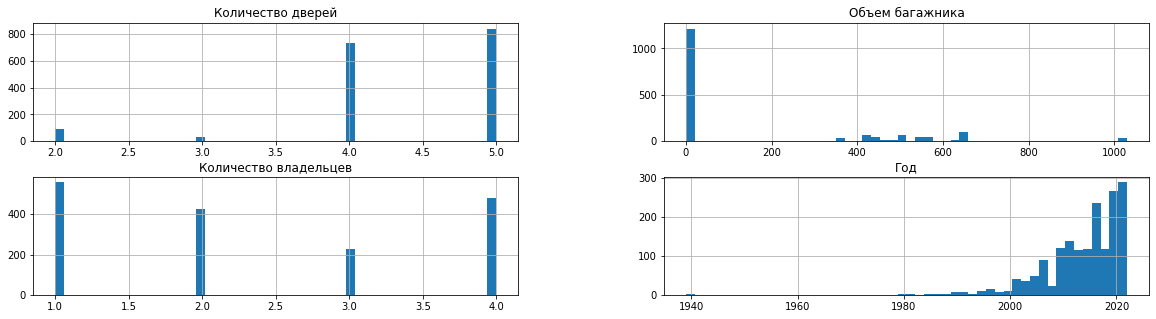

In [58]:
data[discrete_features] = data[discrete_features].astype('int')
data[discrete_features].info()
discrete_hist = data[discrete_features].hist(bins=50, figsize=(20,5))

In [59]:
def count_uniques(lst):
    counts = {}
    for i in range(len(lst)):
        if lst[i] in counts:
            counts[lst[i]] += 1
        else:
            counts[lst[i]] = 1
    return counts.keys(), counts.values()

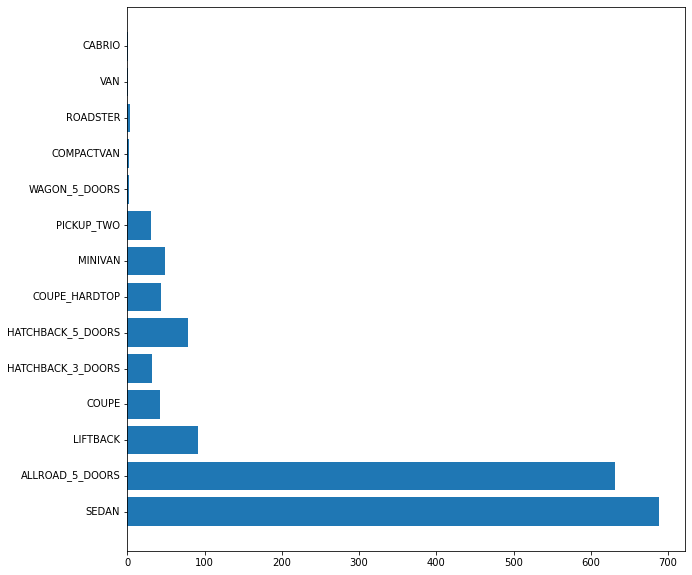

In [60]:
fig, axes = plt.subplots(len(cat_features)-2, 1, figsize=(15, 20))
for i in range(len(cat_features)):
    if cat_features[i] == 'Модель автомобиля' or cat_features[i] == 'Тип автомобиля':
        labels, values = count_uniques(list(data[cat_features[i]]))
        position = np.arange(len(labels))
        fig, ax = plt.subplots()
        ax.barh(position, values)
        ax.set_yticks(position)
        labels = ax.set_yticklabels(labels,
                   verticalalignment =  'center')    #  Вертикальное выравнивание     
        fig.set_figwidth(10)
        fig.set_figheight(10)
    else:
        seaborn.countplot(x=cat_features[i], data=data, ax=axes[int(i % (len(cat_features)-2))])

Видим, что среди категориальных признаков тоже есть выбросы. Это может в дальнейшем осложнить, например, классификацию.
Скорее всего, если мы будем использовать DBScan, эти объекты автоматически отнесутся к выбросам, но все же не стоит о них забывать.

P.S. поскольку парсили мы автомобили конкретно по марке Mерседес, то и признак этот имеет всего одно значение, изменив парсер, **в дальнейшем мы конечно же можем сравнивать автомобили разных марок**.
Можно так же, например, попробовать предсказывать марки автомобилей по имеющимся параметрам бинарным классификатором (то же самое можно делать и для других бинарных категорий).

# Проверим гипотезу о влиянии года машины на цену

Исключительно ради примера проверим, насколько статистически значимая разница (на уровне p-value = 0.05) между ценой автомобилей до 2000 года (включительно) и после.

In [61]:
x = data['Год']
y = data['Рубли']

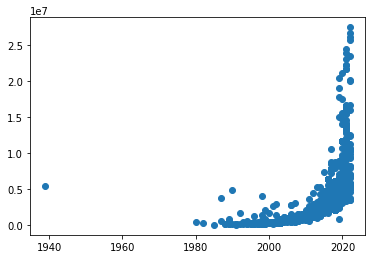

In [62]:
plt.scatter(x, y)
plt.show()

Уже сейчас заметна зависимость в данных.

Видим выброс 1939 года, посмотрим на него внимательнее:

In [63]:
data.loc[data['Год'] == 1939]

,Рубли,Пробег,Количество дверей,Объем багажника,Количество владельцев,Год,С салона,Цвет,Временная зона,Марка автомобиля,Модель автомобиля,Тип автомобиля
644,5430000,1000,2,0,1,1939,False,#FAFBFB,MSK,Mercedes-Benz,W142,CABRIO


Удалим этот объект, т.к. он является сильной аномалией по сравнению с остальными.

In [64]:
data = data.loc[data['Год'] != 1939]
#data.info()

In [65]:
x = data['Год']
y = data['Рубли']

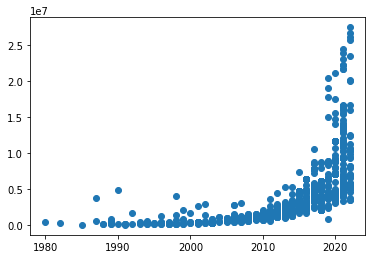

In [66]:
plt.scatter(x, y)
plt.show()

Интересен тот факт, что автомобили среди объявления Mersedes начинают появляться с ~80-х годов выпуска - тогда наладились массовое производство автомобилей и их поставки в Россию.

In [67]:
# stand_1 = preprocessing.StandardScaler()
# stand_2 = preprocessing.MaxAbsScaler()
stand_3 = preprocessing.MinMaxScaler()

In [68]:
# Параметры стандартизации:
stand_3.fit(data[real_features+discrete_features])

# Преобразуем данные, получим X - матрицу класса numpy.ndarray.
X = stand_3.transform(data[real_features+discrete_features]) 

# Преобразуем X в объект класса pandas.DataFrame:
X = pd.DataFrame(X, index=data[real_features+discrete_features].index, columns=data[real_features+discrete_features].columns)

In [69]:
x = X.loc[data['Год'] > 2000]['Рубли']
y = X.loc[data['Год'] <= 2000]['Рубли']
x.name, y.name = 'Year>2000', 'Year<=2000'

In [70]:
from statsmodels.stats.weightstats import zconfint
print('95% confidence interval for the ', x.name, ' mean: [%f, %f]' % zconfint(x))
print('95% confidence interval for the ', y.name, ' mean: [%f, %f]' % zconfint(y))

95% confidence interval for the  Year>2000  mean: [0.156696, 0.171303]
95% confidence interval for the  Year<=2000  mean: [0.011507, 0.027161]


Интервалы не пересекаются, это уже многое говорит о разнице значений в данных, однако проверим все же до конца:

In [71]:
def two_histograms(x, y):
    x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
    y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])

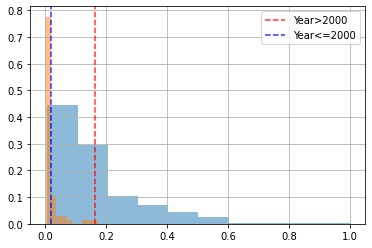

In [72]:
import numpy as np
two_histograms(x, y)

Выборки явно не распределены нормально - видны правые хвосты (можно конечно в таком случае посмотреть на логарифм).
В таком случае не будем применять критерий Стьюдента и воспользуемся сразу Манна-Уитни:

In [73]:
res = stats.mannwhitneyu(x, y, method="asymptotic")[1]
print('p-value: ', res)

p-value:  3.0150238326482374e-34


Нулевая гипотеза о равенстве средних выборок уверенно отвергается. Можно сделать **логический ожидаемый вывод о том, что с увеличением года выпуска(уменьшением возраста машины), цена увеличивается**.

Сделаем ради примера проверку еще и перестановочным критерием.

In [74]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [75]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [76]:
import itertools
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

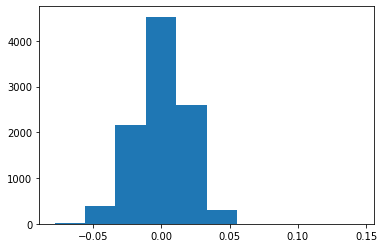

In [77]:
plt.hist(permutation_zero_dist_ind(x, y, max_combinations = 10000))
plt.show()

In [78]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [79]:
print ("p-value: %f" % permutation_test(x, y, max_permutations = 10000))

p-value: 0.000100


Нулевая гипотеза снова отвергается - **есть статистически значимая зависимость между годом выпуска и ценой**.

# Попробуем сделать простенькую кластеризацию KMeans

In [80]:
from sklearn.cluster import KMeans

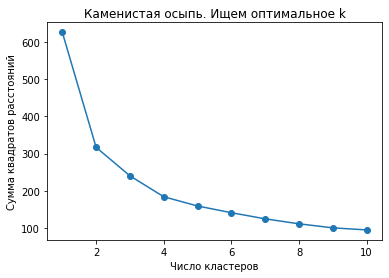

In [81]:
# Параметры стандартизации:
stand_3.fit(data[real_features + discrete_features])

# Преобразуем данные, получаем матрицу класса numpy.ndarray:
X = stand_3.transform(data[real_features + discrete_features]) 

# Преобразуем её в объект класса pandas.DataFrame:
X = pd.DataFrame(X, index=data[real_features + discrete_features].index, 
                 columns=data[real_features + discrete_features].columns)

K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(X) for k in K]
dist = [model.inertia_ for model in models]

# Строим график каменистая осыпь:
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное k')
plt.show()

Исходя из графика Каменистой осыпи, наиболее разумным кажется разделение датасета на 3-4 кластера. Попробуем 4:

In [82]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(X)

#  К таблице добавим марки кластеров:
X['cluster'] = model.labels_
X.groupby('cluster').mean()

,Пробег,Рубли,Количество дверей,Объем багажника,Количество владельцев,Год
cluster,,,,,,
0,0.329684,0.046109,0.735690,0.025491,0.930976,0.663340
1,0.072880,0.249132,0.883041,0.000000,0.132908,0.903395
2,0.091468,0.197906,0.907986,0.560424,0.216146,0.903832
3,0.196050,0.095877,0.000000,0.314716,0.629213,0.790530


In [83]:
X.groupby('cluster').size()

Попробуем приближенно проинтерпретировать полученную кластеризацию.
- **1-й кластер** - сюда попали наиболее дорогие машины: мы можем видеть, что средний год таких машин тоже достаточно высок (т.е. скорее всего они преимущественно новые), параметры пробега и количества владельцев низкие, при этом это судя по всему машины без багажника
- **2-й кластер** - сюда тоже попали достаточно дорогие машины, с небольшим пробегом и количеством владельцев, свежим годом, но при этом достаточно большим багажником
- **3-й кластер** - более дешевые и старые машины, обладают бОльшим пробегом, по сравнению с предыдущими двумя
- **0-й кластер** - машины с самым низким средним показателем цены и года, набольшим пробегом

В целом данные логически интерпретируются. Для более точной кластеризации **следует учитывать наличие выбросов по целочисленным параметрам.**

# Попробуем сделать простенькую кластеризацию DBScan

In [84]:
from sklearn.cluster import DBSCAN

In [85]:
from sklearn import preprocessing

stand_1 = preprocessing.StandardScaler()
# stand_2 = preprocessing.MaxAbsScaler()
# stand_3 = preprocessing.MinMaxScaler()

X2 = X.drop(['cluster'], axis=1)

# Параметры стандартизации:
stand_1.fit(data[real_features + discrete_features])

# Преобразуем данные, получаем матрицу класса numpy.ndarray:
X2 = stand_1.transform(data[real_features + discrete_features]) 

# Преобразуем её в объект класса pandas.DataFrame:
X2 = pd.DataFrame(X2, index=data[real_features + discrete_features].index, 
                 columns=data[real_features + discrete_features].columns)

In [86]:
#  Создадим объект DBSCAN, зададим значения параметров:
dbscan = DBSCAN(eps=1.31, metric='euclidean', min_samples=3)

#  Обучим модель DBSCAN:
dbscan.fit(X2)

# В какой кластер попало наблюдение - np-массив номеров кластеров:
dbscan.labels_

# Таблица частот: 
unique, counts = np.unique(dbscan.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  -1   17]
 [   0 1564]
 [   1   64]
 [   2   29]
 [   3   20]]


P.S. Можно еще поподбирать параметры eps и min_samples для получения более 'приятной' классификации. Можно также почистить данные от очевидных выбросов или попробовать обобщить некоторые категории.

## t-SNE

In [87]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # - цветовые схемы для графиков

In [88]:
data_subset = X.drop(['cluster'], axis=1)
response_subset = X['cluster']

In [89]:
import warnings
warnings.filterwarnings("ignore")

method = TSNE(random_state=321)
tsne_representation = method.fit_transform(data_subset)

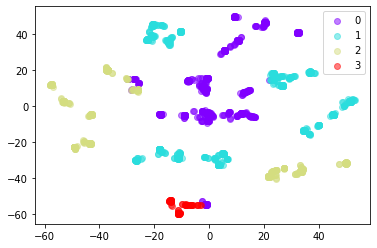

In [90]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, color in zip(set(response_subset), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0],
                tsne_representation[response_subset.values==y, 1], c=color.reshape(1,-1), alpha=0.5, label=str(y))
plt.legend()

Можно сделать выводы, что простенький Kmeans действительно выделил классы не слишком плохо. 

Если уделить больше времени анализу, выбору подходящей модели и параметров для нее, можно сделать кластеризацию лучше.